In [19]:
! pip install psycopg2-binary

import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
#Init de la connexion à la db 
conn = ps.connect(
    host="54.36.191.217",
    port="5432",
    dbname="postgres",
    user="postgres",
    password="epsi-test-abc")

In [21]:
# Fetch des datas
pdf = sqlio.read_sql_query("SELECT fk_annee as annees, taux_pouvoir_achat from mspr_ia.fait_taux where taux_pouvoir_achat IS NOT NULL", conn)
pdf

C:\Users\allen\AppData\Local\Temp\ipykernel_3928\1784652339.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pdf = sqlio.read_sql_query("SELECT fk_annee as annees, taux_pouvoir_achat from mspr_ia.fait_taux where taux_pouvoir_achat IS NOT NULL", conn)


annees  taux_pouvoir_achat
0     2022              -0.344
1     2021               2.084
2     2020              -0.264
3     2019               1.958
4     2018               0.778
..     ...                 ...
58    1964               4.094
59    1963               4.600
60    1962               8.067
61    1961               3.631
62    1960               6.666

[63 rows x 2 columns]

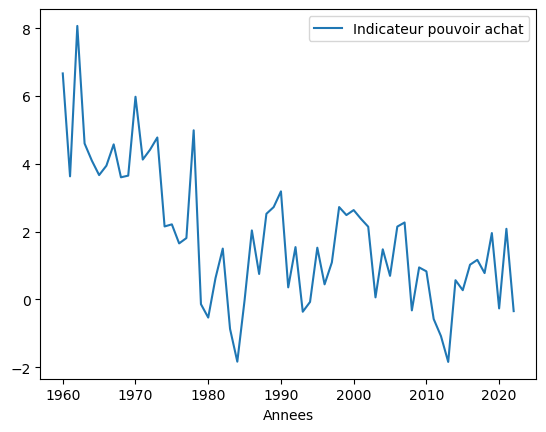

In [22]:
#Visualisation du df

x_data = pdf.annees
y_data1 = pdf.taux_pouvoir_achat

fig, ax = plt.subplots()
ax.plot(x_data, y_data1, label='Indicateur pouvoir achat')
ax.set_xlabel('Annees')
ax.legend()
plt.show()

In [23]:
# Analyse statistique du dataset

pdf.describe()

annees  taux_pouvoir_achat
count    63.000000           63.000000
mean   1991.000000            1.862476
std      18.330303            2.038378
min    1960.000000           -1.842000
25%    1975.500000            0.401500
50%    1991.000000            1.653000
75%    2006.500000            2.956500
max    2022.000000            8.067000

In [24]:
# Le jeu de données semble assez propre et ne semble pas contenir d'outlayers
# Regression linéaire pour afin de mettre en relation les depenses et recette

# Recuperation du nombre de vote par annee du premier parti de notre echantillon

nb_votes_com = sqlio.read_sql_query("select \"FK_ANNEE\" as \"annees\", sum(nombre_de_votes) as \"nb_total_vote\", \"FK_PARTI\" as \"partis\" from mspr_ia.fait_vote where \"FK_PARTI\" = 'COM' group by \"FK_PARTI\", \"FK_ANNEE\" order by \"FK_ANNEE\"", conn)

nb_votes_com

C:\Users\allen\AppData\Local\Temp\ipykernel_3928\1739684712.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  nb_votes_com = sqlio.read_sql_query("select \"FK_ANNEE\" as \"annees\", sum(nombre_de_votes) as \"nb_total_vote\", \"FK_PARTI\" as \"partis\" from mspr_ia.fait_vote where \"FK_PARTI\" = 'COM' group by \"FK_PARTI\", \"FK_ANNEE\" order by \"FK_ANNEE\"", conn)


annees  nb_total_vote partis
0     1958          90429    COM
1     1962          89129    COM
2     1967         119713    COM
3     1973         112165    COM
4     1978         122020    COM
5     1981          74453    COM
6     1988          54271    COM
7     1993          43948    COM
8     1997          54502    COM
9     2002          17170    COM
10    2007          25175    COM
11    2012            290    COM
12    2017          83259    COM
13    2022          83259    COM

In [25]:
# Jointure des deux dataframes
final_pdf_com = pd.merge(pdf, nb_votes_com, on="annees")
final_pdf_com

annees  taux_pouvoir_achat  nb_total_vote partis
0     2022              -0.344          83259    COM
1     2017               1.168          83259    COM
2     2012              -1.080            290    COM
3     2007               2.270          25175    COM
4     2002               2.145          17170    COM
5     1997               1.092          54502    COM
6     1993              -0.362          43948    COM
7     1988               2.526          54271    COM
8     1981               0.629          74453    COM
9     1978               4.989         122020    COM
10    1973               4.777         112165    COM
11    1967               4.574         119713    COM
12    1962               8.067          89129    COM

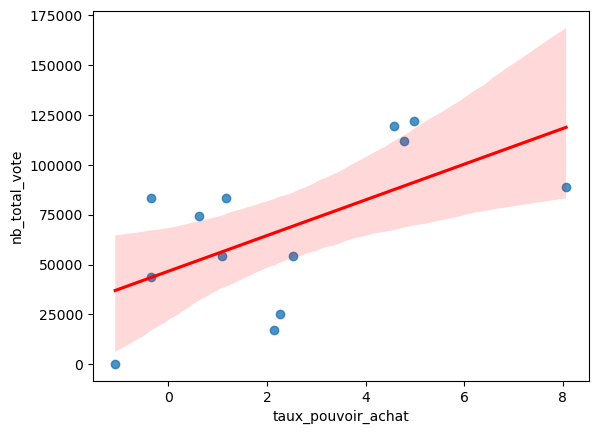

In [26]:
# Regression linéaire entre le pouvoir d'achat et les votes:

ax = sns.regplot(x="taux_pouvoir_achat",y="nb_total_vote", data=final_pdf_com, line_kws={"color": "red"})

In [27]:
#Il semblererait qu'il y ai une légère corrélation entre nos deux variable
# Selection d'un autre parti

nb_votes_exd = sqlio.read_sql_query("select \"FK_ANNEE\" as \"annees\", sum(nombre_de_votes) as \"nb_total_vote\", \"FK_PARTI\" as \"partis\" from mspr_ia.fait_vote where \"FK_PARTI\" = 'EXD' group by \"FK_PARTI\", \"FK_ANNEE\" order by \"FK_ANNEE\"", conn)

nb_votes_exd

C:\Users\allen\AppData\Local\Temp\ipykernel_3928\3501391770.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  nb_votes_exd = sqlio.read_sql_query("select \"FK_ANNEE\" as \"annees\", sum(nombre_de_votes) as \"nb_total_vote\", \"FK_PARTI\" as \"partis\" from mspr_ia.fait_vote where \"FK_PARTI\" = 'EXD' group by \"FK_PARTI\", \"FK_ANNEE\" order by \"FK_ANNEE\"", conn)


annees  nb_total_vote partis
0     1958           1621    EXD
1     1962              0    EXD
2     1967              0    EXD
3     1973           3880    EXD
4     1978           5760    EXD
5     1981           2981    EXD
6     1988            310    EXD
7     1993           1040    EXD
8     1997           2222    EXD
9     2002           7387    EXD
10    2007           1519    EXD
11    2017           1764    EXD
12    2022           1764    EXD

In [28]:
# Jointure des deux dataframes
final_pdf_exd = pd.merge(pdf, nb_votes_exd, on="annees")
final_pdf_exd

annees  taux_pouvoir_achat  nb_total_vote partis
0     2022              -0.344           1764    EXD
1     2017               1.168           1764    EXD
2     2007               2.270           1519    EXD
3     2002               2.145           7387    EXD
4     1997               1.092           2222    EXD
5     1993              -0.362           1040    EXD
6     1988               2.526            310    EXD
7     1981               0.629           2981    EXD
8     1978               4.989           5760    EXD
9     1973               4.777           3880    EXD
10    1967               4.574              0    EXD
11    1962               8.067              0    EXD

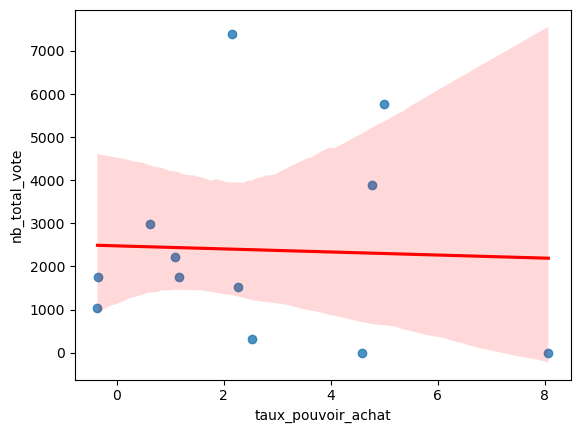

In [29]:
ax = sns.regplot(x="taux_pouvoir_achat",y="nb_total_vote", data=final_pdf_exd, line_kws={"color": "red"})

In [30]:
# A contrario ici il ne semble pas y avoir de corrélation

# Passons à l'analyse pour les partis DIV

nb_votes_div = sqlio.read_sql_query("select \"FK_ANNEE\" as \"annees\", sum(nombre_de_votes) as \"nb_total_vote\", \"FK_PARTI\" as \"partis\" from mspr_ia.fait_vote where \"FK_PARTI\" = 'DIV' group by \"FK_PARTI\", \"FK_ANNEE\" order by \"FK_ANNEE\"", conn)
nb_votes_div

C:\Users\allen\AppData\Local\Temp\ipykernel_3928\3493178715.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  nb_votes_div = sqlio.read_sql_query("select \"FK_ANNEE\" as \"annees\", sum(nombre_de_votes) as \"nb_total_vote\", \"FK_PARTI\" as \"partis\" from mspr_ia.fait_vote where \"FK_PARTI\" = 'DIV' group by \"FK_PARTI\", \"FK_ANNEE\" order by \"FK_ANNEE\"", conn)


annees  nb_total_vote partis
0    1958           2235    DIV
1    1962           1121    DIV
2    1967              0    DIV
3    1993          16243    DIV
4    1997           6029    DIV
5    2002          16452    DIV
6    2007           3800    DIV
7    2012           1875    DIV
8    2017          57480    DIV
9    2022          57480    DIV

In [31]:
final_pdf_div = pd.merge(pdf, nb_votes_div, on="annees")
final_pdf_div

annees  taux_pouvoir_achat  nb_total_vote partis
0    2022              -0.344          57480    DIV
1    2017               1.168          57480    DIV
2    2012              -1.080           1875    DIV
3    2007               2.270           3800    DIV
4    2002               2.145          16452    DIV
5    1997               1.092           6029    DIV
6    1993              -0.362          16243    DIV
7    1967               4.574              0    DIV
8    1962               8.067           1121    DIV

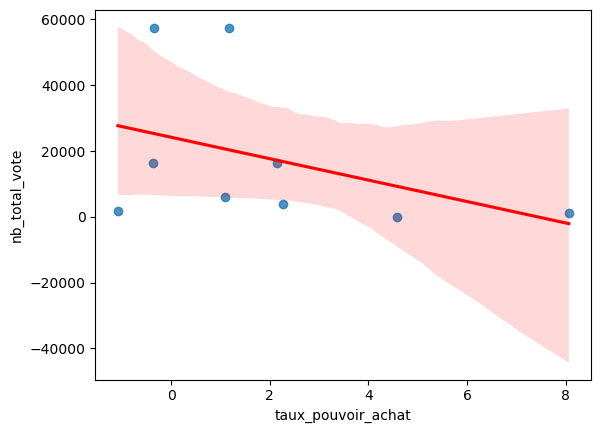

In [32]:
ax = sns.regplot(x="taux_pouvoir_achat",y="nb_total_vote", data=final_pdf_div, line_kws={"color": "red"})


In [33]:
# Ici non plus la coorélation n'est pas évidente puisqu'une majeure partie des points se trouve au alentours de 0
# et ne semblent pas suivre la courbe